<img src="//ww.namu.la/s/28e1136aa9ac150b5490ca2fd7dfecfa12c95358a3db02b6802bda967879e7e92a2c45541c8debfef91c4d8b06f2e694a52342ae1712d34acf8ac99ab9d8862f3b7332145b7b042dfcf3af57de675f26ab84d35ae6f8db2003193bba889e386a" height="50px" width="50px" align='left'>



# 도쿄올림픽 야구대표팀 출전선수들 OPS 예측

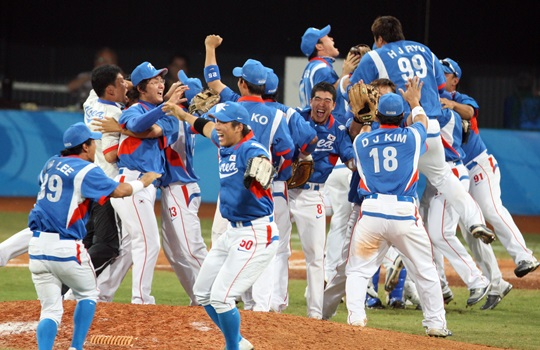

## Why OPS?

On-base Plus Slugging. OPS는 야구에서 타자들을 평가하는 스탯 중 하나로 '출루율 + 장타율'로 계산한다.

출루율이 높다는 의미는 득점이 될 확률이 높다 / 장타율이 높다는것은 히팅능력이 뛰어나다는 것을 의미한다

올림픽은 단기전이다. 찬스에 강한 클러치능력과 출루가 중요한데, OPS가 거기에 중요한 지표라 생각하여 기준으로 잡았다.   

---

## 라이브러리 설치

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# 모델평가
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

<AxesSubplot:title={'center':'한글폰트'}>

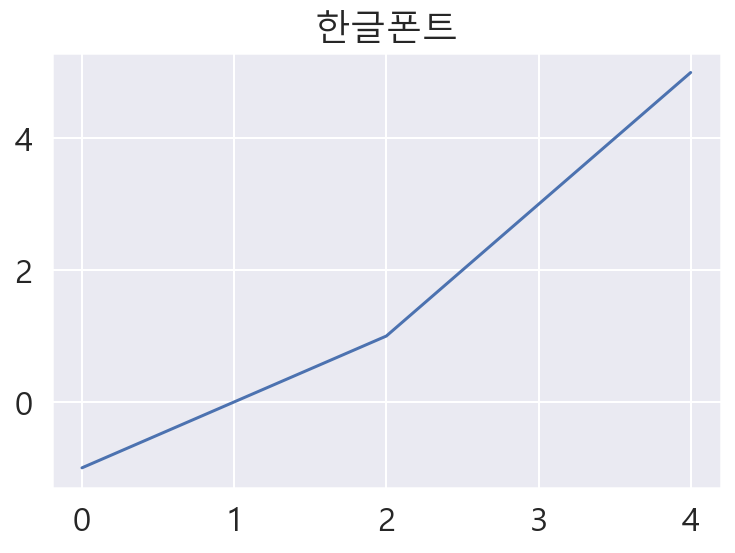

In [104]:
plt.rc("font", family="Malgun Gothic") #한글 폰트 
plt.rc("axes", unicode_minus=False) #마이너스 코드 

from IPython.display import set_matplotlib_formats #폰트 선명하게 설정.
set_matplotlib_formats('retina') 

pd.Series([-1,0,1,3,5]).plot(title="한글폰트") # 한글폰트와 마이너스 폰트 설정 확인

## 데이터 불러오기

**데이터 선정 이유**

- 가장 최근에 한 대회라 최신 데이터
   

- 올림픽과 프리미어12는 다른 대회이지 않은가?? <br>
    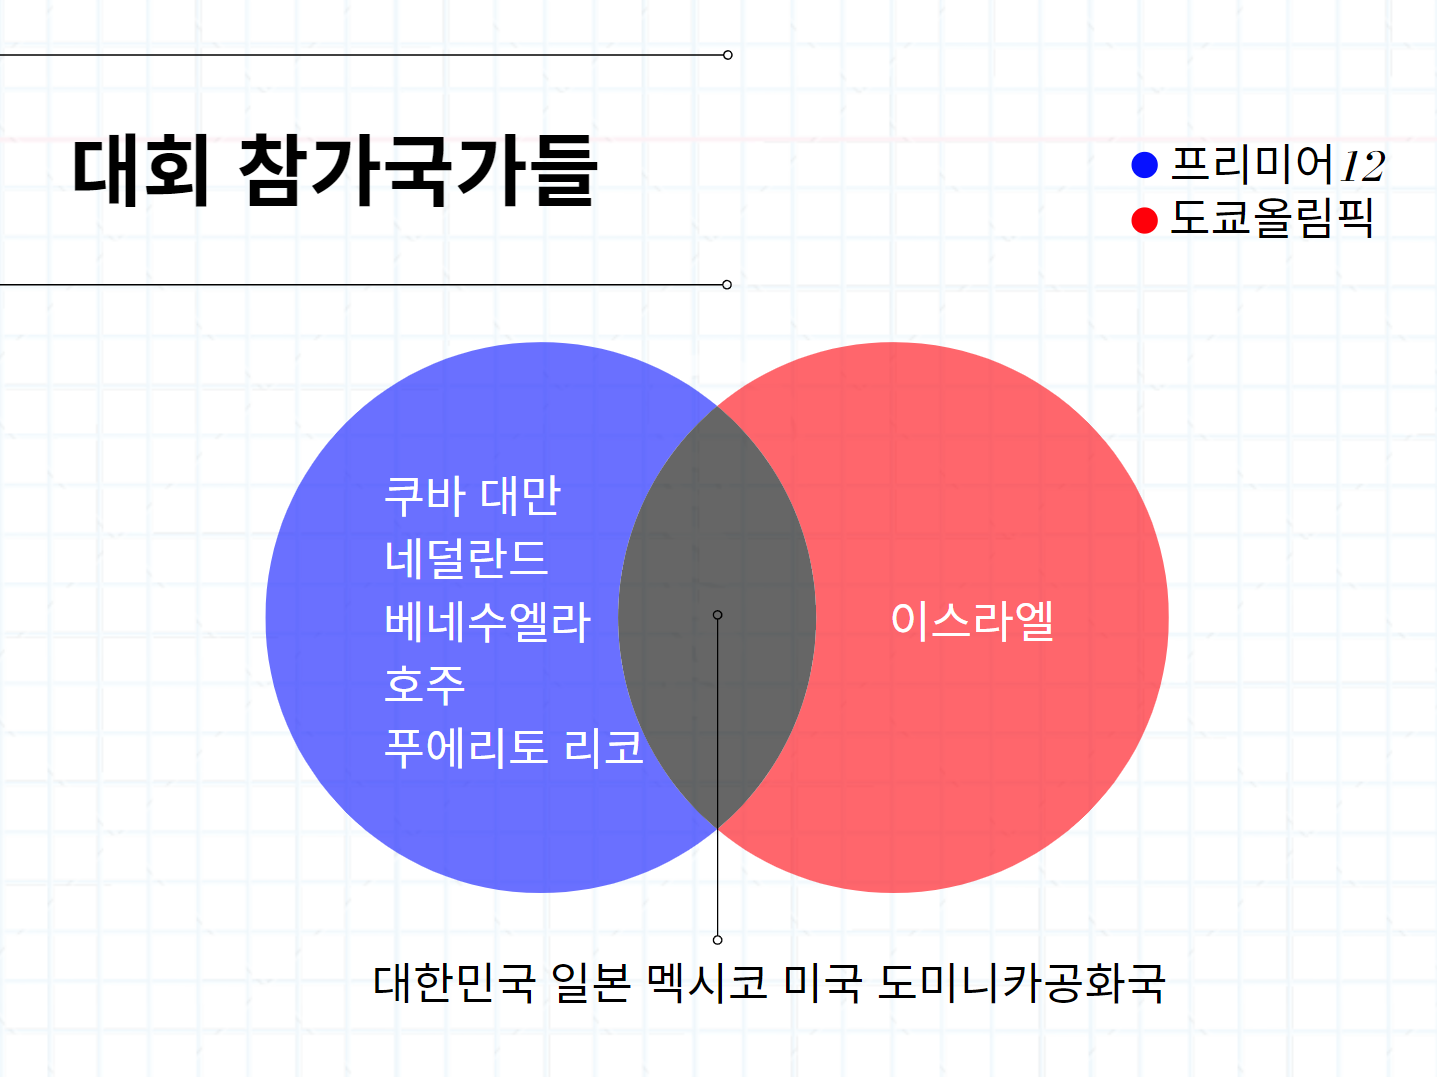
    


 -> 올림픽 대표팀은 프리미어12 대표팀에 나왔던 팀 중에서 이스라엘 하나의 팀만 추가되었을 정도로 두 대회의 심한 차이를 찾을 수 없었다.
 
 -> 개최나라가 일본, 대표팀 감독 등 야구 성적에 외적으로 영향을 주는 환경들이 거의 유사한 점을 보아 적합한 데이터라 판단하였다.  
 

In [42]:
df_season = pd.read_csv('2019_premier_player_season.csv')
df_premier = pd.read_csv('19_premier.csv')

print(df_season.shape)
print(df_premier.shape)
df_season.head()

(144, 36)
(13, 15)


PLAYER TEAM    YEAR  RES  ORD   P   SP    AB    R     H  ...    AVG    OBP  \
0    김재환   두산  2019.0  7.0    4  LF  9.0  32.0  5.0   9.0  ...  0.211  0.407   
1    김재환   두산  2019.0  5.0    4  LF  9.0  32.0  3.0   9.0  ...  0.266  0.361   
2    김재환   두산  2019.0  6.0    4  LF  9.0  32.0  9.0  10.0  ...  0.281  0.370   
3    김재환   두산  2019.0  5.0    4  LF  9.0  36.0  9.0  14.0  ...  0.305  0.396   
4    김재환   두산  2019.0  6.0    4  LF  9.0  36.0  4.0  11.0  ...  0.313  0.392   

     SLG   ISOP    OPS    GPA      PN   avLI   RE24    WPA  
0  0.450  0.239  0.857  0.296  16.778  1.134  0.471  0.040  
1  0.524  0.258  0.885  0.293  15.333  0.859  0.007  0.007  
2  0.469  0.189  0.839  0.284  16.778  0.954  0.603  0.052  
3  0.546  0.241  0.942  0.315  15.778  0.769  0.544  0.055  
4  0.529  0.215  0.920  0.309  13.778  1.039 -0.087  0.015  

[5 rows x 36 columns]

---

## 데이터 칼럼명 설명

- 결과(RES) : 경기 결과를 WIN : 1, LOSE : 0
- 타순(ORD) : 1~9번까지의 결과 타순을 의미
- P : position을 의미
- 선발(SP) : 선발 출장의 유무를 나타냄(1, 0)
- 타수(AB) : 타석에 서서 했던 기록 행위들을 나타냄.(?)
- 득점(R) : 주자로서 점수를 얻은 행위
- 안타(H)
- 1루타(B)
- 2루타(2B)
- 3루타(3B)
- 홈런(HR)
- 장타(XBH)
- 루타(TB) : 모두 루타 합친 것.
- 타점(RBI)
- 도루(SB)
- 도실(CS) : 도루실패
- 볼넷(BB)
- 사구(HBP)
- 고의4구(IBB)
- 삼진(SO)
- 병살타(GDP)
- 희타(SH) : 희생번트
- 희비(SF) : 희생플라이
- 타율(AVG)
- 출루율(OBP)
- 장타율(SLG)
- 순수장타율(ISOP)
- OPS : 출루율 + 장타율
- GPA : (1.8*출루율 + 장타율) / 4
- 투구수 (PN) : 타석당 투구수
- avLI :
- RE24 :
- WPA :
- 이름(PLAYER)
- 팀(TEAM)
- 연도(YEAR)

---

## 1. 데이터 전처리

### 1-1. 데이터 정제

In [43]:
new_columns=['PLAYER','경기','SP','AS','H','2B','3B','HR','RBI','SB','AVG','OBI','SLG','OPS','YEAR']

df_premier.columns = new_columns

# 필요 없는 칼럼 제거 
df_premier = df_premier.drop('경기', axis=1)

In [44]:
# OPS 예측 모델을 만들기 위해 데이터들을 merge
df_anal = pd.merge(df_season,df_premier[['PLAYER','OPS']], on='PLAYER')
df_anal = df_anal.rename(columns={'OPS_y':'OPS(sea)', 'OPS_x':'OPS'}) #이름을 바꿔준다. 
print(df_anal.shape)
df_anal.head()

(144, 37)


PLAYER TEAM    YEAR  RES  ORD   P   SP    AB    R     H  ...    OBP    SLG  \
0    김재환   두산  2019.0  7.0    4  LF  9.0  32.0  5.0   9.0  ...  0.407  0.450   
1    김재환   두산  2019.0  5.0    4  LF  9.0  32.0  3.0   9.0  ...  0.361  0.524   
2    김재환   두산  2019.0  6.0    4  LF  9.0  32.0  9.0  10.0  ...  0.370  0.469   
3    김재환   두산  2019.0  5.0    4  LF  9.0  36.0  9.0  14.0  ...  0.396  0.546   
4    김재환   두산  2019.0  6.0    4  LF  9.0  36.0  4.0  11.0  ...  0.392  0.529   

    ISOP    OPS    GPA      PN   avLI   RE24    WPA  OPS(sea)  
0  0.239  0.857  0.296  16.778  1.134  0.471  0.040      0.53  
1  0.258  0.885  0.293  15.333  0.859  0.007  0.007      0.53  
2  0.189  0.839  0.284  16.778  0.954  0.603  0.052      0.53  
3  0.241  0.942  0.315  15.778  0.769  0.544  0.055      0.53  
4  0.215  0.920  0.309  13.778  1.039 -0.087  0.015      0.53  

[5 rows x 37 columns]

In [45]:
ch = ['RES', 'ORD', 'SP', 'AB', 'R', 'H', 'B',
       '2B', '3B', 'HR', 'XBH', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB',
       'SO', 'GDP', 'SH', 'SF']
df_anal[ch] = df_anal[ch].astype(int)

In [46]:
df_anal['OPS(sea)'] = df_anal['OPS(sea)'].apply(lambda x :'{:.3f}'.format(x))

In [47]:
df_anal = df_anal.drop(['YEAR', 'TEAM', 'P', 'PLAYER'], axis=1)
df_anal.head()

RES  ORD  SP  AB  R   H   B  2B  3B  HR  ...    OBP    SLG   ISOP    OPS  \
0    7    4   9  32  5   9   5   1   0   3  ...  0.407  0.450  0.239  0.857   
1    5    4   9  32  3   9   7   1   1   0  ...  0.361  0.524  0.258  0.885   
2    6    4   9  32  9  10   7   1   0   2  ...  0.370  0.469  0.189  0.839   
3    5    4   9  36  9  14   9   2   0   3  ...  0.396  0.546  0.241  0.942   
4    6    4   9  36  4  11  10   0   1   0  ...  0.392  0.529  0.215  0.920   

     GPA      PN   avLI   RE24    WPA  OPS(sea)  
0  0.296  16.778  1.134  0.471  0.040     0.530  
1  0.293  15.333  0.859  0.007  0.007     0.530  
2  0.284  16.778  0.954  0.603  0.052     0.530  
3  0.315  15.778  0.769  0.544  0.055     0.530  
4  0.309  13.778  1.039 -0.087  0.015     0.530  

[5 rows x 33 columns]

### 1-2. 결측치 확인

In [48]:
df_anal.isnull().sum()

RES         0
ORD         0
SP          0
AB          0
R           0
H           0
B           0
2B          0
3B          0
HR          0
XBH         0
TB          0
RBI         0
SB          0
CS          0
BB          0
HBP         0
IBB         0
SO          0
GDP         0
SH          0
SF          0
AVG         0
OBP         0
SLG         0
ISOP        0
OPS         0
GPA         0
PN          0
avLI        0
RE24        0
WPA         0
OPS(sea)    0
dtype: int64

결측치가 없다는 것을 확인하였다. 

반응변수로 쓰일 19년도 프리미어 타자 OPS를 보겠다.

In [49]:
df_anal['OPS(sea)'].describe()

count       144
unique        9
top       1.061
freq         18
Name: OPS(sea), dtype: object

<AxesSubplot:>

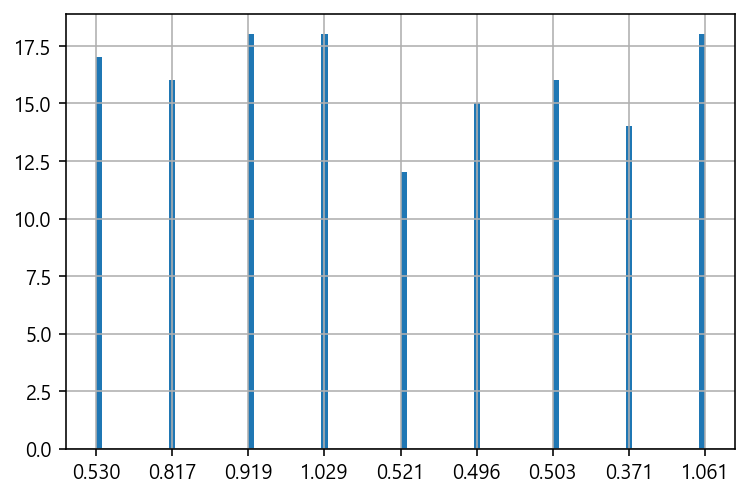

In [50]:
df_anal['OPS(sea)'].hist(bins=100)

In [51]:
df_anal['OPS(sea)'] = df_anal['OPS(sea)'].astype(float)
df_anal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RES       144 non-null    int32  
 1   ORD       144 non-null    int32  
 2   SP        144 non-null    int32  
 3   AB        144 non-null    int32  
 4   R         144 non-null    int32  
 5   H         144 non-null    int32  
 6   B         144 non-null    int32  
 7   2B        144 non-null    int32  
 8   3B        144 non-null    int32  
 9   HR        144 non-null    int32  
 10  XBH       144 non-null    int32  
 11  TB        144 non-null    int32  
 12  RBI       144 non-null    int32  
 13  SB        144 non-null    int32  
 14  CS        144 non-null    int32  
 15  BB        144 non-null    int32  
 16  HBP       144 non-null    int32  
 17  IBB       144 non-null    int32  
 18  SO        144 non-null    int32  
 19  GDP       144 non-null    int32  
 20  SH        144 non-null    int32 

머신러닝 예측모델을 위한 최종 데이터이다. 

In [52]:
df_anal.head()

RES  ORD  SP  AB  R   H   B  2B  3B  HR  ...    OBP    SLG   ISOP    OPS  \
0    7    4   9  32  5   9   5   1   0   3  ...  0.407  0.450  0.239  0.857   
1    5    4   9  32  3   9   7   1   1   0  ...  0.361  0.524  0.258  0.885   
2    6    4   9  32  9  10   7   1   0   2  ...  0.370  0.469  0.189  0.839   
3    5    4   9  36  9  14   9   2   0   3  ...  0.396  0.546  0.241  0.942   
4    6    4   9  36  4  11  10   0   1   0  ...  0.392  0.529  0.215  0.920   

     GPA      PN   avLI   RE24    WPA  OPS(sea)  
0  0.296  16.778  1.134  0.471  0.040      0.53  
1  0.293  15.333  0.859  0.007  0.007      0.53  
2  0.284  16.778  0.954  0.603  0.052      0.53  
3  0.315  15.778  0.769  0.544  0.055      0.53  
4  0.309  13.778  1.039 -0.087  0.015      0.53  

[5 rows x 33 columns]

In [53]:
len(df_anal.columns)

33

- 최종적으로 총 33개 변수 (32개의 설명변수, 1개의 반응변수)로 정하였다. 

### 1-3. 데이터 스케일링

In [54]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float모양으로 출력되게 해준다. 
pd.options.mode.chained_assignment = None

In [55]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의한다. 

def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x : (x-series_mean) / series_std)
    return df

In [56]:
# 피처 각각에 대한 scaling을 수행한다. 
scale_columns = df_anal[df_anal.columns.difference(['OPS(sea)'])].columns
df_anal = standard_scaling(df_anal, scale_columns)

In [57]:
df_anal.head()

RES       ORD        SP        AB         R         H         B  \
0  1.493915  0.920209  0.506557 -0.398870 -0.285753 -0.448129 -0.771268   
1  0.132372  0.920209  0.506557 -0.398870 -1.108723 -0.448129 -0.085696   
2  0.813144  0.920209  0.506557 -0.398870  1.360186 -0.118891 -0.085696   
3  0.132372  0.920209  0.506557  0.655025  1.360186  1.198058  0.599875   
4  0.813144  0.920209  0.506557  0.655025 -0.697238  0.210346  0.942661   

         2B        3B        HR  ...       OBP       SLG      ISOP       OPS  \
0 -0.636065 -0.481137  1.764949  ...  0.205535 -0.215912  0.985233 -0.101076   
1 -0.636065  1.498397 -0.819654  ... -0.917786  0.524833  1.213944  0.113418   
2 -0.636065 -0.481137  0.903414  ... -0.698006 -0.025720  0.383360 -0.238964   
3  0.057824 -0.481137  1.764949  ... -0.063085  0.745055  1.009308  0.550065   
4 -1.329953  1.498397 -0.819654  ... -0.160765  0.574884  0.696334  0.381535   

        GPA        PN      avLI      RE24       WPA  OPS(sea)  
0 -0.031538  0.319287  0.646739  0.864143  0.710386      0.53  
1 -0.107230 -0.293790 -0.981726 -0.408360 -0.177970      0.53  
2 -0.334305  0.319287 -0.419165  1.226148  1.033425      0.53  
3  0.447843 -0.104987 -1.514678  1.064342  1.114185      0.53  
4  0.296459 -0.953537  0.084178 -0.666152  0.037389      0.53  

[5 rows x 33 columns]

가독성을 위해 데이터 분리 전, OPS(sea) 변수명을 y로 변경해주겠다.

In [58]:
df_anal = df_anal.rename(columns={'OPS(sea)':'y'})
df_anal.columns

Index(['RES', 'ORD', 'SP', 'AB', 'R', 'H', 'B', '2B', '3B', 'HR', 'XBH', 'TB',
       'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB', 'SO', 'GDP', 'SH', 'SF', 'AVG',
       'OBP', 'SLG', 'ISOP', 'OPS', 'GPA', 'PN', 'avLI', 'RE24', 'WPA', 'y'],
      dtype='object')

### 1-4. 상관분석

**상관행렬**

In [59]:
df_anal.corr()

RES       ORD        SP        AB         R         H         B  \
RES   1.000000  0.145272  0.063519  0.051914  0.316259  0.239983  0.158292   
ORD   0.145272  1.000000 -0.112850 -0.364141 -0.204658 -0.224440 -0.253600   
SP    0.063519 -0.112850  1.000000  0.530582  0.197247  0.212746  0.172380   
AB    0.051914 -0.364141  0.530582  1.000000  0.265816  0.518214  0.439891   
R     0.316259 -0.204658  0.197247  0.265816  1.000000  0.457482  0.220947   
H     0.239983 -0.224440  0.212746  0.518214  0.457482  1.000000  0.813681   
B     0.158292 -0.253600  0.172380  0.439891  0.220947  0.813681  1.000000   
2B    0.058359 -0.091608 -0.009461  0.209882  0.228287  0.443062 -0.014970   
3B    0.111254 -0.283942 -0.116561  0.062054  0.003956  0.083683  0.058128   
HR    0.109258  0.287394  0.185933 -0.037148  0.356643 -0.014822 -0.390837   
XBH   0.146687  0.031917  0.078690  0.159634  0.409080  0.364399 -0.244837   
TB    0.251282 -0.019213  0.223642  0.348251  0.570426  0.713663  0.220830   
RBI   0.276964  0.187934  0.192129  0.149150  0.365830  0.282301 -0.053339   
SB    0.043847 -0.381883  0.130107  0.248524  0.317177  0.186060  0.213658   
CS    0.065513 -0.269339 -0.052033 -0.139453 -0.056570  0.081473  0.065975   
BB    0.125260  0.020153  0.201852 -0.350158  0.193579 -0.218653 -0.230097   
HBP   0.000725  0.004549 -0.047604 -0.323588  0.082330 -0.103366 -0.088650   
IBB   0.120559  0.264629  0.108971 -0.054113 -0.029330 -0.016209 -0.052140   
SO    0.052588  0.283834  0.173225 -0.012506  0.030658 -0.264959 -0.320787   
GDP   0.079178 -0.133062  0.022128  0.113382  0.110919  0.023877 -0.015478   
SH   -0.035378 -0.122923  0.080563  0.151304 -0.060787 -0.032489  0.027021   
SF   -0.044779  0.076404  0.180863 -0.127418 -0.015298 -0.017890 -0.019411   
AVG  -0.092398 -0.174358 -0.072501 -0.027875  0.167385  0.337627  0.271087   
OBP  -0.069714  0.032179 -0.013181 -0.202027  0.145925  0.162917  0.059591   
SLG   0.110841  0.308640 -0.001813 -0.230138  0.134575  0.110910 -0.099400   
ISOP  0.181962  0.461915  0.035810 -0.261715  0.074185 -0.043732 -0.261845   
OPS   0.062743  0.245555 -0.005655 -0.239087  0.148561  0.136228 -0.056686   
GPA   0.038196  0.208972 -0.008681 -0.238639  0.153262  0.146096 -0.034171   
PN    0.017370 -0.322539  0.515929  0.356875  0.333316  0.119389  0.093978   
avLI -0.057595  0.025075 -0.272053 -0.029394 -0.081663 -0.127842 -0.117764   
RE24  0.320552  0.061427  0.046926 -0.051044  0.507010  0.564661  0.262706   
WPA   0.374486  0.030399  0.049846 -0.061514  0.393656  0.437525  0.220434   
y     0.079350 -0.259624  0.154153  0.400558 -0.010630  0.108327  0.157140   

            2B        3B        HR  ...       OBP       SLG      ISOP  \
RES   0.058359  0.111254  0.109258  ... -0.069714  0.110841  0.181962   
ORD  -0.091608 -0.283942  0.287394  ...  0.032179  0.308640  0.461915   
SP   -0.009461 -0.116561  0.185933  ... -0.013181 -0.001813  0.035810   
AB    0.209882  0.062054 -0.037148  ... -0.202027 -0.230138 -0.261715   
R     0.228287  0.003956  0.356643  ...  0.145925  0.134575  0.074185   
H     0.443062  0.083683 -0.014822  ...  0.162917  0.110910 -0.043732   
B    -0.014970  0.058128 -0.390837  ...  0.059591 -0.099400 -0.261845   
2B    1.000000 -0.144882  0.018464  ...  0.101906  0.093931  0.018506   
3B   -0.144882  1.000000 -0.182453  ... -0.222574 -0.168905 -0.186687   
HR    0.018464 -0.182453  1.000000  ...  0.246886  0.496935  0.601940   
XBH   0.762962  0.046454  0.601387  ...  0.176266  0.344222  0.346527   
TB    0.520470  0.080892  0.631042  ...  0.245634  0.391008  0.346611   
RBI   0.197386  0.019652  0.619145  ...  0.176574  0.339221  0.413573   
SB    0.082175  0.034959 -0.167363  ...  0.128769 -0.127738 -0.256775   
CS   -0.009539  0.306159 -0.074026  ...  0.115823  0.041629 -0.074718   
BB   -0.124136 -0.246434  0.267529  ...  0.264477  0.188450  0.211874   
HBP  -0.130711 -0.045295  0.134326  ...  0.158743  0.184367  0.207833   
IBB   0.010708 -0.163279  0.146398  ...  0.0

상관행렬과 산점도는 변수가 많아 가독성이 매우 떨어지므로 아래 히트맵으로 상관분석을 마치도록 하겠다.

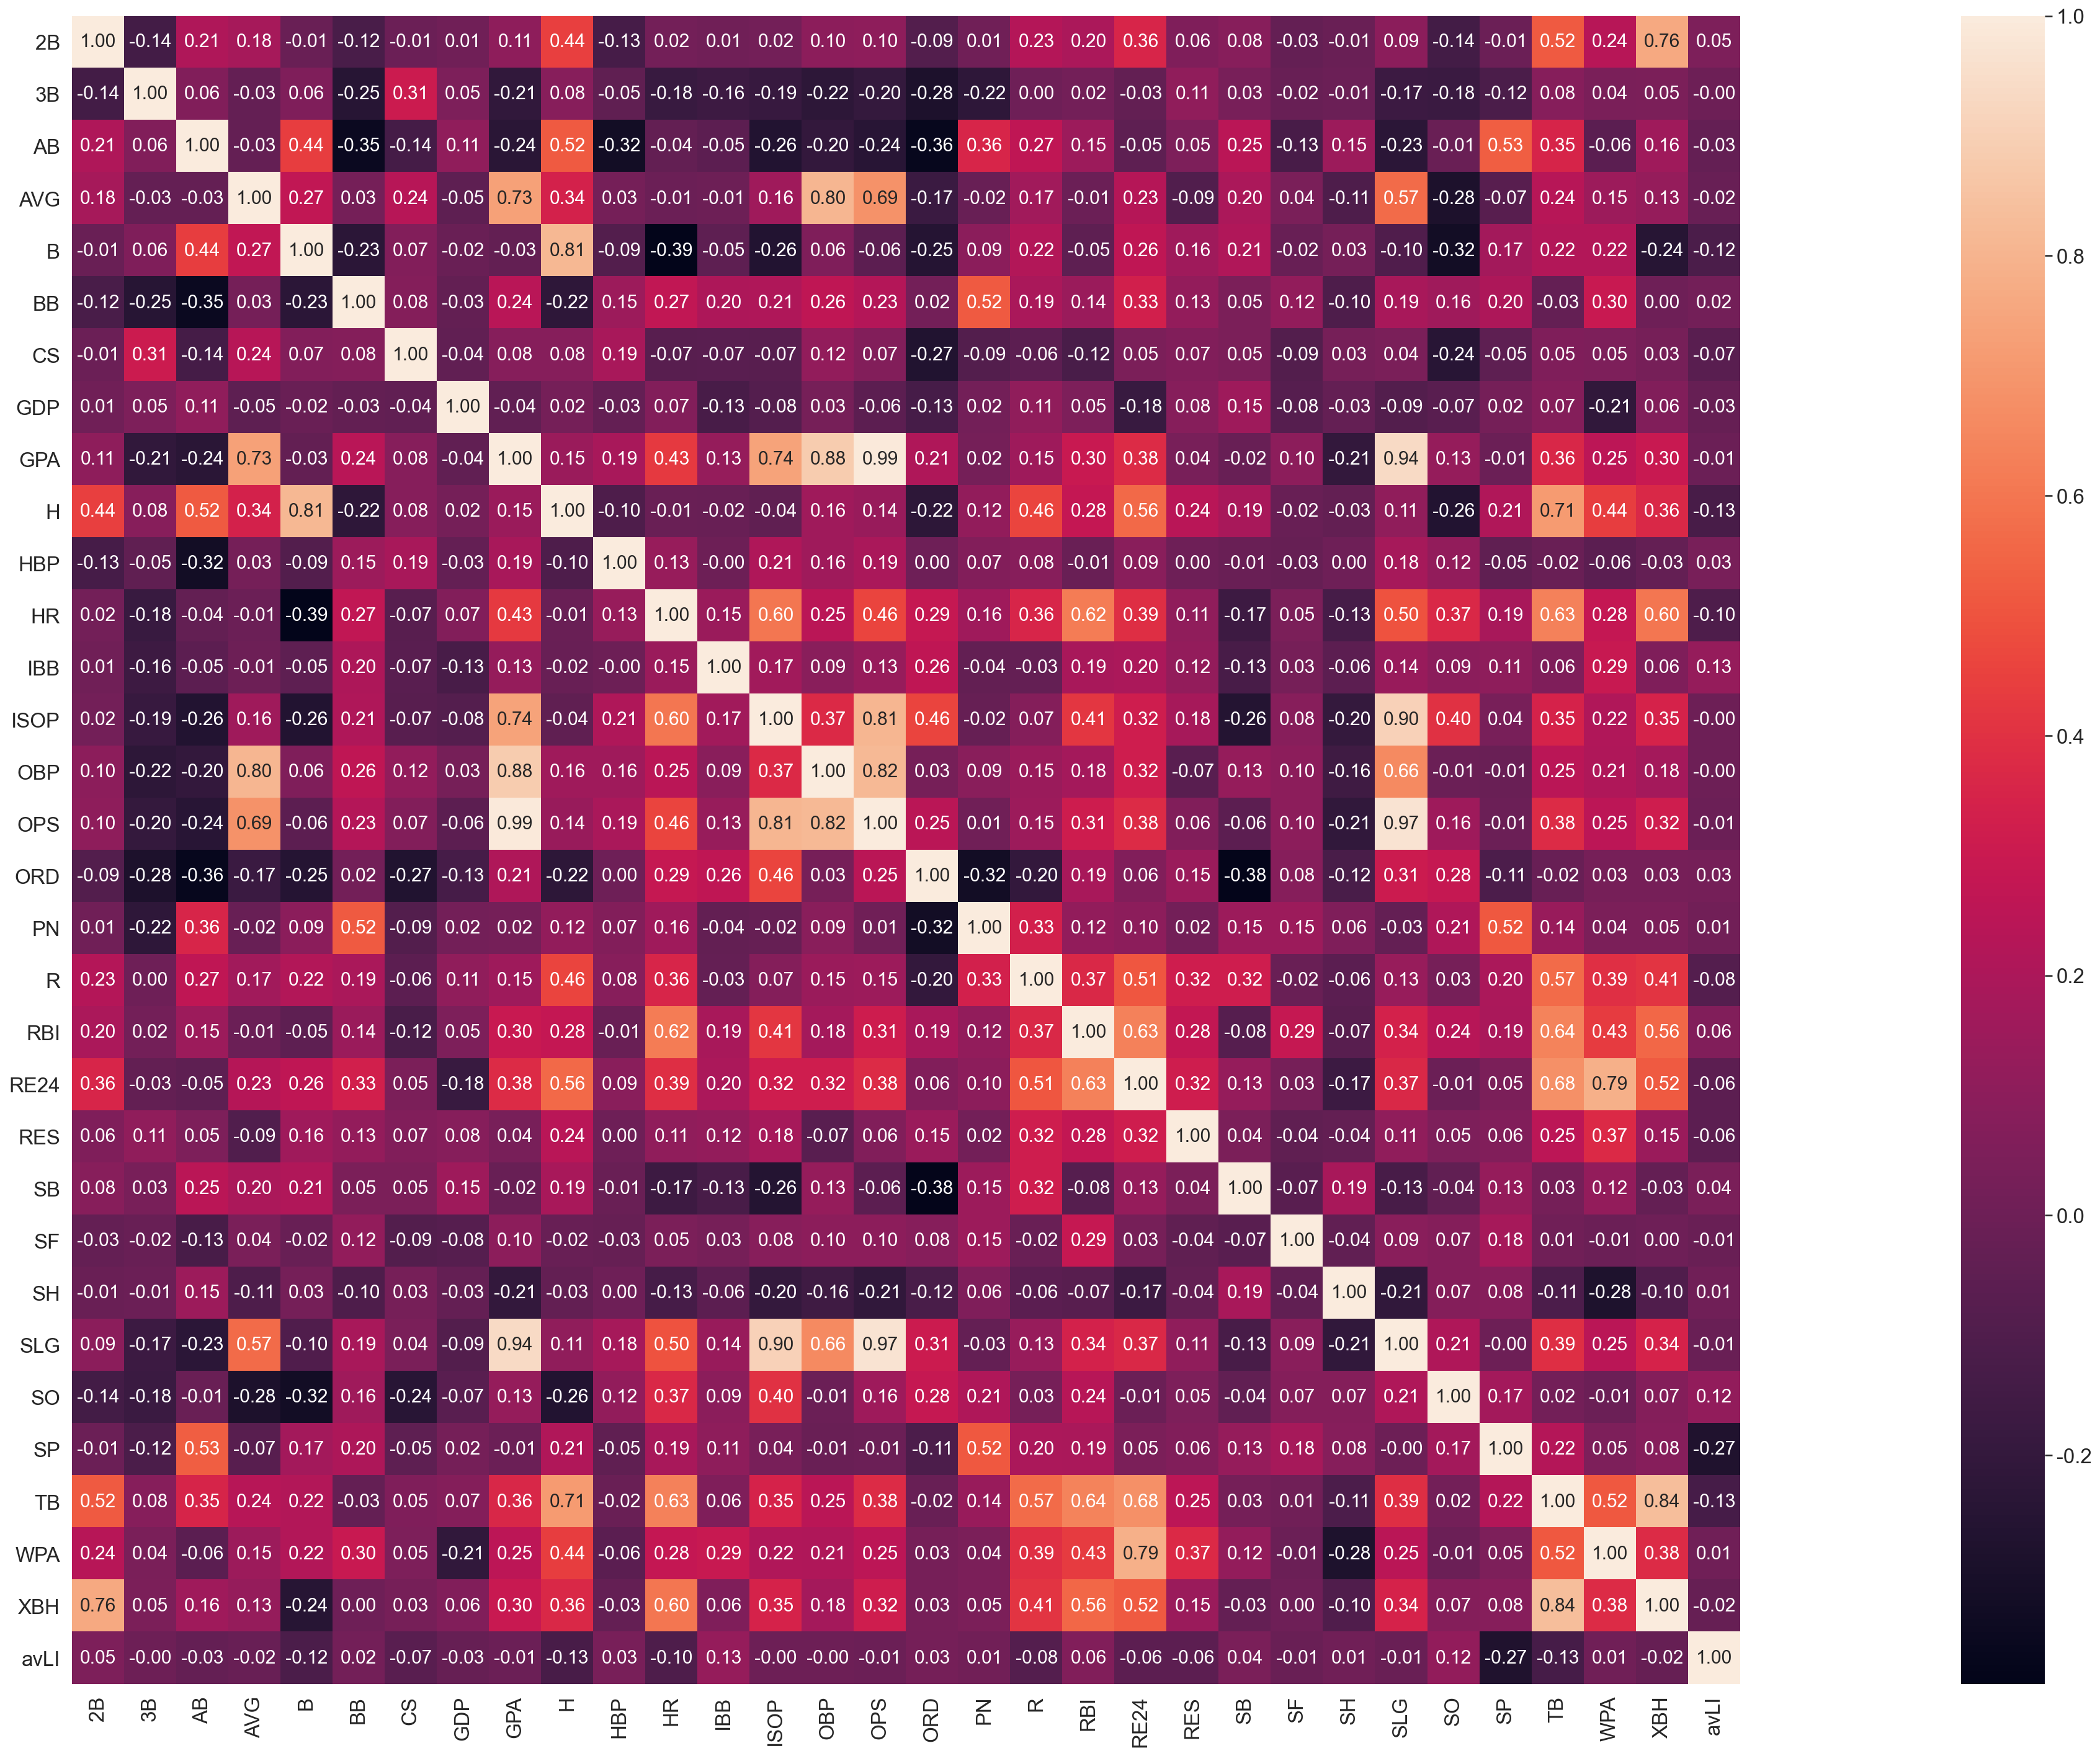

In [60]:
plt.figure(figsize=(50, 20))
# 피처간의 상관계수 행렬을 계산합니다.
corr = df_anal[scale_columns].corr(method='pearson')
# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothicOTF')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=scale_columns,
            xticklabels=scale_columns)

plt.tight_layout()
plt.show()

### 1-5. 데이터 분할

In [61]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터를 분리한다. 
X = df_anal[df_anal.columns.difference(['y'])]
y = df_anal['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 2. 선형회귀 모델 구축

### 2.1. 선형회귀 모델 가정 확인.

In [62]:
X_train = sm.add_constant(X_train) #벡터 제로값이 될 변수를 만들어야함.(값은 1로 구성됨)
model = sm.OLS(y_train, X_train, axis=1) # fit : 학습
model_trained = model.fit()

### 2.2. 모델 검정

생성한 회귀모델이 적절한 모델인지를 검정하는 과정이 필요하다. 

회귀분석이 지닌 기본적인 가정인 정규성, 선형성, 독립성, 등분산성을 검정하는 과정을 거쳐 모델이 적절한지를 파악하는 과정이 필요하다. 

**2.2.1 오차의 정규성 확인**

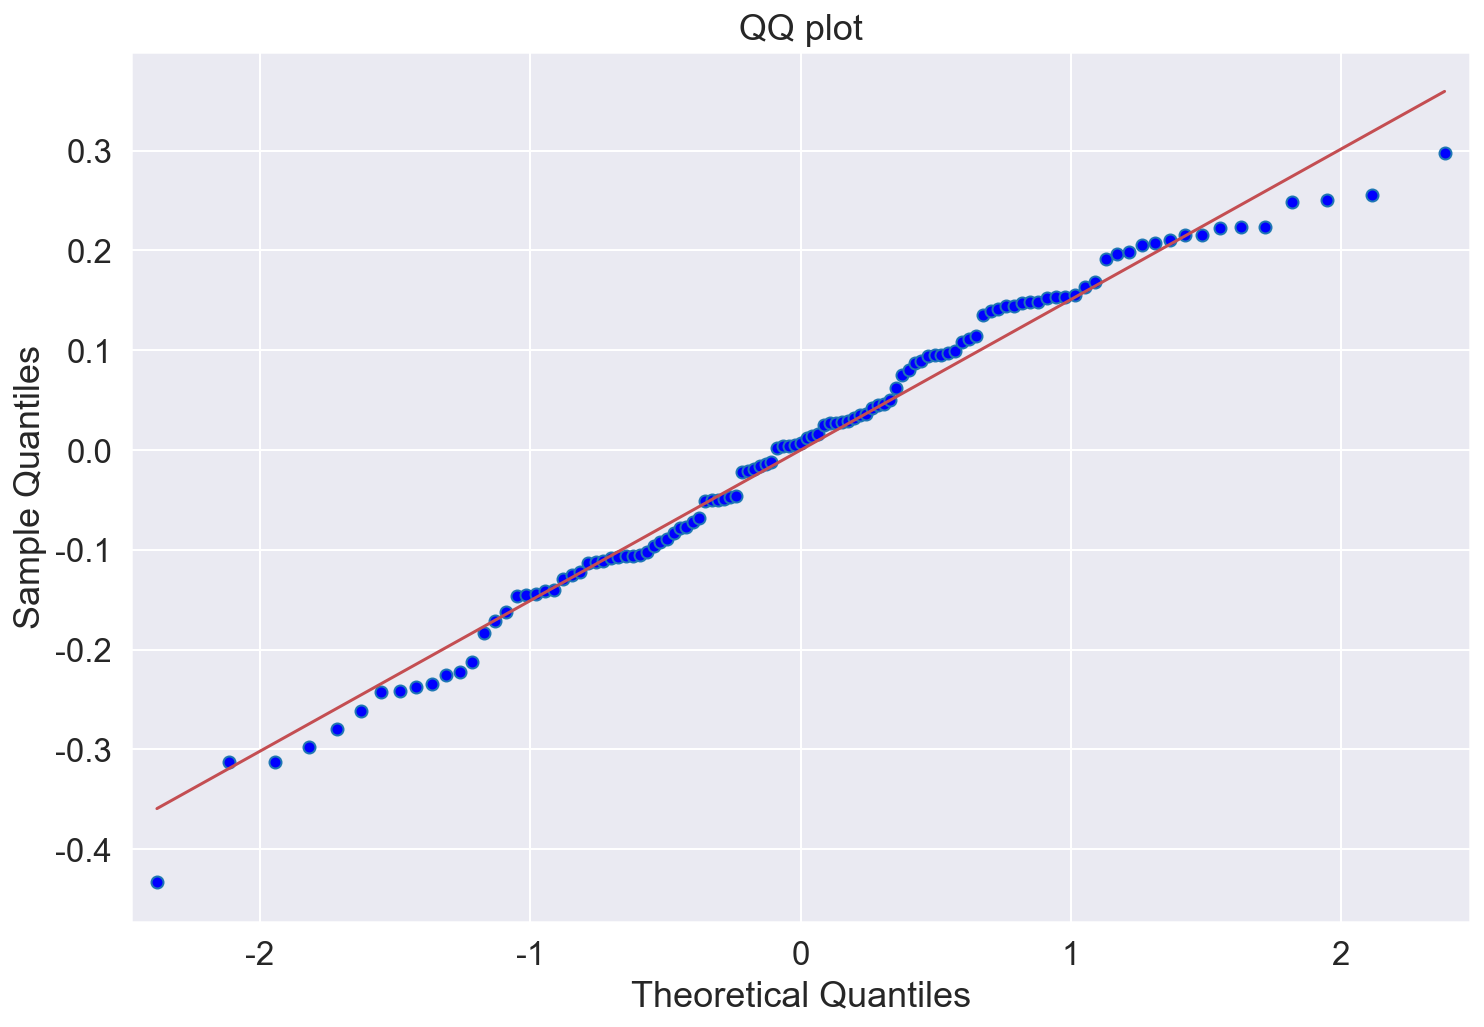

In [63]:
from scipy.stats import probplot
 
model_residuals = model_trained.resid

fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(12)

sm.ProbPlot(model_residuals).qqplot(line='s', color='#1f77b4', ax=ax)
ax.title.set_text('QQ plot')

오차의 정규성이 만족한다는 것을 알 수 있다. 

In [64]:
## 이론상 잔차값 계산
sqrt_mse = np.sqrt(model_trained.mse_resid) ## square root of mse
std_res = model_trained.resid/sqrt_mse ## studentized residual
 
## Shapiro-Wilks 테스트의 검정통계량과 p-value를 계산한다.
shapiro_test = stats.shapiro(std_res)
 
sw_stat = shapiro_test[0] ## S-W 검정 통계량
p_value = shapiro_test[1] ## p_value

print(sw_stat)
p_value

0.9819303750991821


0.12378933280706406

가장 검정력이 좋은 Shapiro-Wilks테스트를 이용해서 수치적으로 확인하였다.

p_value값이 0.12로 귀무가설이 채택되기에, 오차항의 정규성을 만족한다고 할 수 있다.  

#### 2.2.2 오차의 등분산성 확인

[Text(0.5, 0, 'Fitted values'), Text(0, 0.5, 'Residuals')]

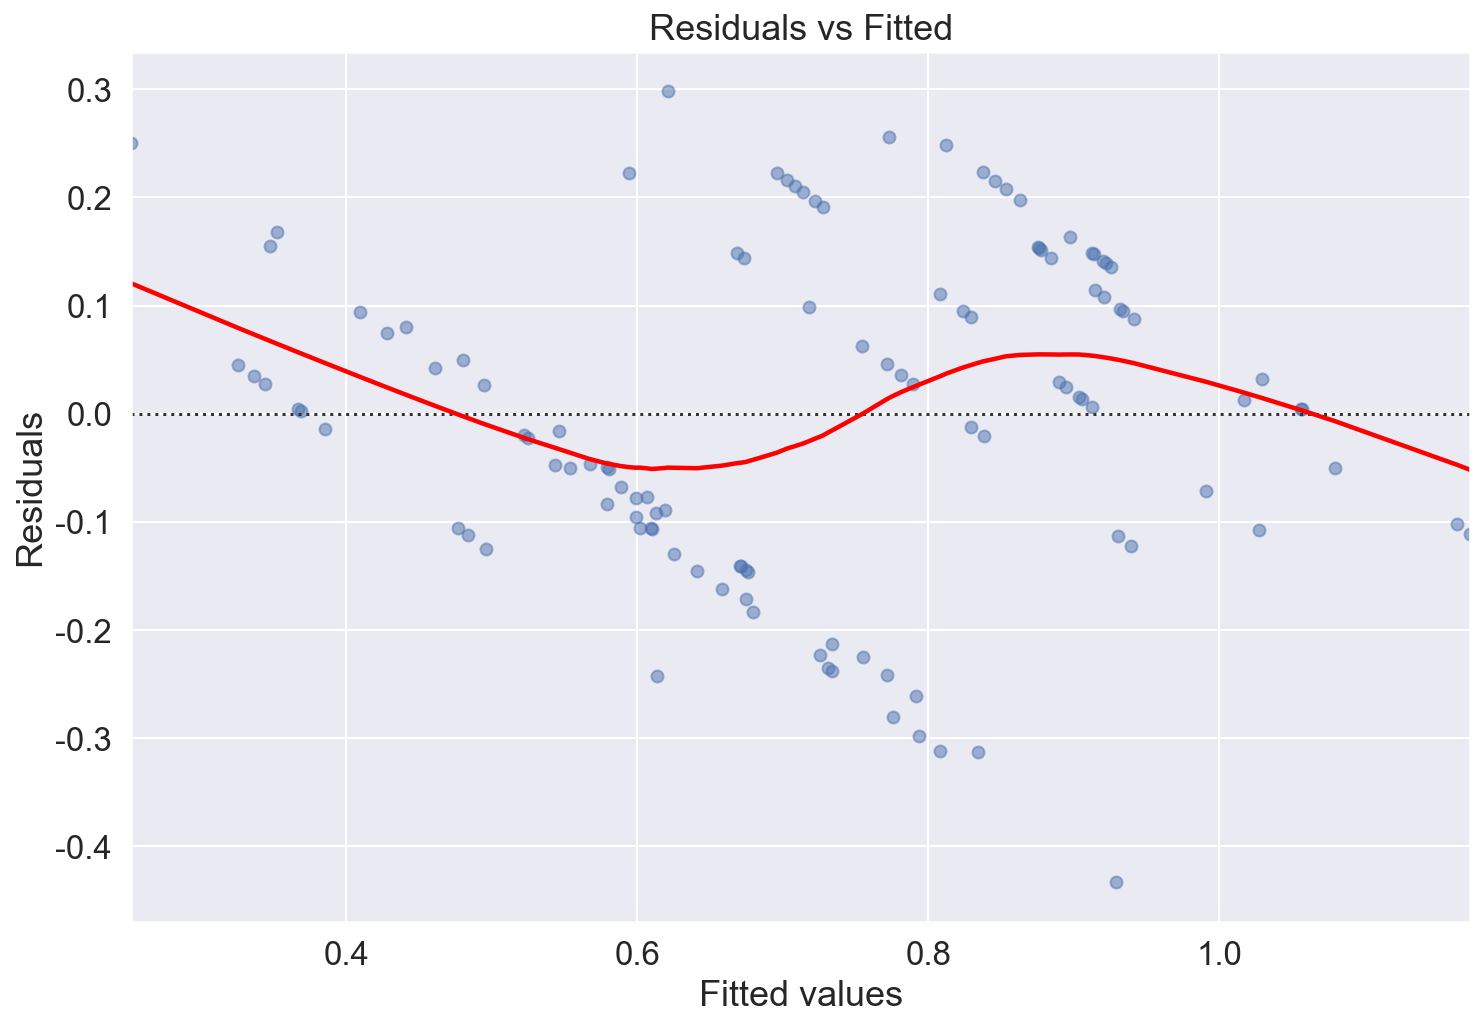

In [65]:
model_fitted_y = model_trained.fittedvalues

fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(12)

sns.residplot(model_fitted_y, y_train, data=X_train, lowess=True, scatter_kws={'alpha': 0.5},
              line_kws={'color':'red'}, ax=ax)
ax.title.set_text('Residuals vs Fitted')
ax.set(xlabel='Fitted values', ylabel='Residuals')

해당 그래프에서 오차들의 선형성이 존재하기 때문에 등분산성을 충족하지 않다.

#### 2.2.3 통계적으로 해석하기

In [66]:
print(model_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5.012
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           3.23e-09
Time:                        15:19:02   Log-Likelihood:                 54.273
No. Observations:                 115   AIC:                            -48.55
Df Residuals:                      85   BIC:                             33.80
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7150      0.017     43.071      0.0

### 2-3. 변수제거 및 변수 선택

- 방법 1. p-value값의 너무 높은 값들 제거
- 방법 2. 다중공선성 위배

In [67]:
new = ['H', 'B', 'XBH', 'OPS']

model = sm.OLS(y_train, X_train.drop(new, axis=1))
model_trained = model.fit()
print(model_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5.251
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           1.39e-09
Time:                        15:19:02   Log-Likelihood:                 54.265
No. Observations:                 115   AIC:                            -50.53
Df Residuals:                      86   BIC:                             29.07
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7150      0.017     43.323      0.0

### 2-4. 예측하기 

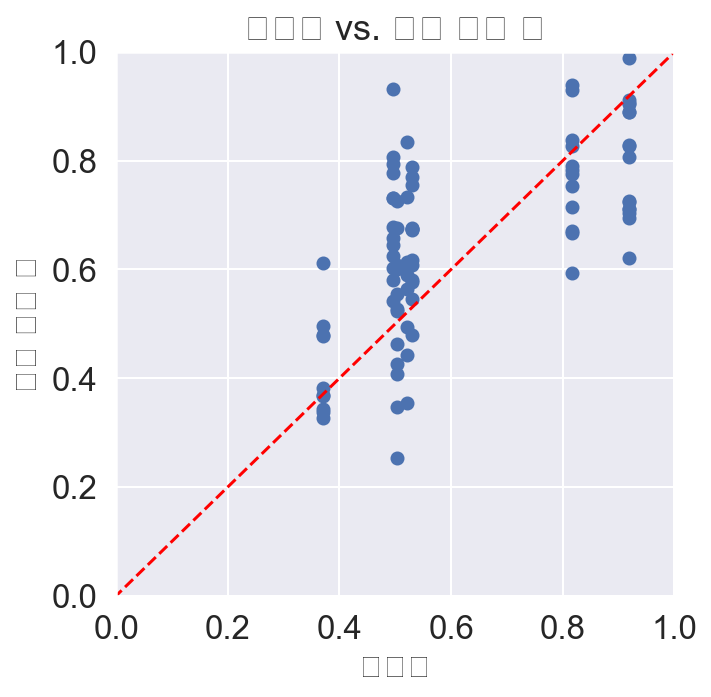

In [68]:
y_train_pred = model_trained.fittedvalues

plt.figure(figsize=(5,5))
plt.title('실제값 vs. 모델 출력 값')
plt.scatter(y_train, y_train_pred)
plt.plot([-5, 55], [-5,55], ls='--', c='red')
plt.xlabel('실제값', size=16)
plt.ylabel('모델 출력 값', size=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

역시나 모델의 성능이 좋지 못하다. 

In [69]:
X_test = sm.add_constant(X_test)

In [70]:
X_test.columns

Index(['const', '2B', '3B', 'AB', 'AVG', 'B', 'BB', 'CS', 'GDP', 'GPA', 'H',
       'HBP', 'HR', 'IBB', 'ISOP', 'OBP', 'OPS', 'ORD', 'PN', 'R', 'RBI',
       'RE24', 'RES', 'SB', 'SF', 'SH', 'SLG', 'SO', 'SP', 'TB', 'WPA', 'XBH',
       'avLI'],
      dtype='object')

In [71]:
y_test_pred = model_trained.predict(X_test.drop(new,axis=1))
y_test_pred.head()

117    0.473626
19     1.021808
82     0.981168
97     0.362576
56     0.617826
dtype: float64

테스트 셋의 값들의 예측값들을 뽑아내 보았다.

### 2-5. 결과 정리

In [72]:
print('Training RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print('Training MAE: {:.3f}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Training R2: {:.3f}'.format(r2_score(y_train, y_train_pred)))

Training RMSE: 0.151
Training MAE: 0.124
Training R2: 0.631


오차가 많이 차이나는 것을 확인할 수 있다. 
여기까지 statsmodels로 다중선형회귀를 나타내봄.

하지만 애초에, 등분산성 위배했기 때문에 엉터리 결과임. 하나의 과정이다. 

---

## 3. 알고리즘별 모델 비교.
- 사이킷런 활용.
- 'RMSE'를 평가기준으로 비교.

### 3-1. 다중선형회귀분석

In [73]:
lr_skl = LinearRegression(fit_intercept=False)
lr_skl.fit(X_train, y_train)
y_pred_skl = lr_skl.predict(X_test)

lr_stat = sm.OLS(y_train, X_train).fit()
y_pred_stat = lr_stat.predict(X_test)

In [74]:
mae = mean_absolute_error(y_test, y_pred_skl)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_skl))
r2score = r2_score(y_test, y_pred_skl)

print('다중선형 회귀분석')
print(f'R2 score:{r2score:0.4f}', f'RMSE:{rmse:0.4f}', f'MAE:{mae:0.4f}', sep='  |  ')

다중선형 회귀분석
R2 score:0.1298  |  RMSE:0.2360  |  MAE:0.1881


### 3-2. Decision Tree Regressor

In [75]:
dtr = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth' : [10,50,100,200],
    'max_leaf_nodes' : [50,100,200],
    'criterion' : ['mae', 'mse']
}

CV_dtr = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=10, verbose=1, n_jobs=-1, scoring='r2')
# 보통 n_jobs=-1, 이것은 사용할 수 있는 변수들을 최대로 사용하겠다. 이거 아니면
# 변수의 2배를 넣는 경우가 허다하다.
CV_dtr.fit(X_train, y_train)

best_dtr = CV_dtr.best_estimator_
best_dtr.fit(X_train, y_train)

y_pred = best_dtr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred = y_pred) ## R2 score
rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred)) ## RMSE
mae = mean_absolute_error(y_true = y_test, y_pred = y_pred) ## MAE

print('Decision Tree Regressor')
print(f'R2 score:{r2score:0.4f}', f'RMSE:{rmse:0.4f}', f'MAE:{mae:0.4f}', sep='  |  ')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Decision Tree Regressor
R2 score:0.5677  |  RMSE:0.1664  |  MAE:0.0882


### 3-3. RandomForest Regressor

In [76]:
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'max_depth' : [10,50,100,200],
    'max_leaf_nodes' : [50,100,200],
    'criterion' : ['mae', 'mse']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1, n_jobs=-1, scoring='r2')
CV_rfr.fit(X_train, y_train)

best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

y_pred = best_rfr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred=y_pred) ## R2 score
rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred)) ## RMSE
mae = mean_absolute_error(y_true = y_test, y_pred=y_pred) ## MAE

print('Random Forest Regressor')
print(f'R2 score:{r2score:0.4f}', f'RMSE:{rmse:0.4f}', f'MAE:{mae:0.4f}', sep='  |  ')


Fitting 10 folds for each of 24 candidates, totalling 240 fits
Random Forest Regressor
R2 score:0.6013  |  RMSE:0.1598  |  MAE:0.1309


In [79]:
# plt.figure(figsize=(20,20))
# _ = tree.plot_tree(
#     rf.estimators_[66], feature_names=X_train.columns, filled=True, impurity=True, rounded=True)

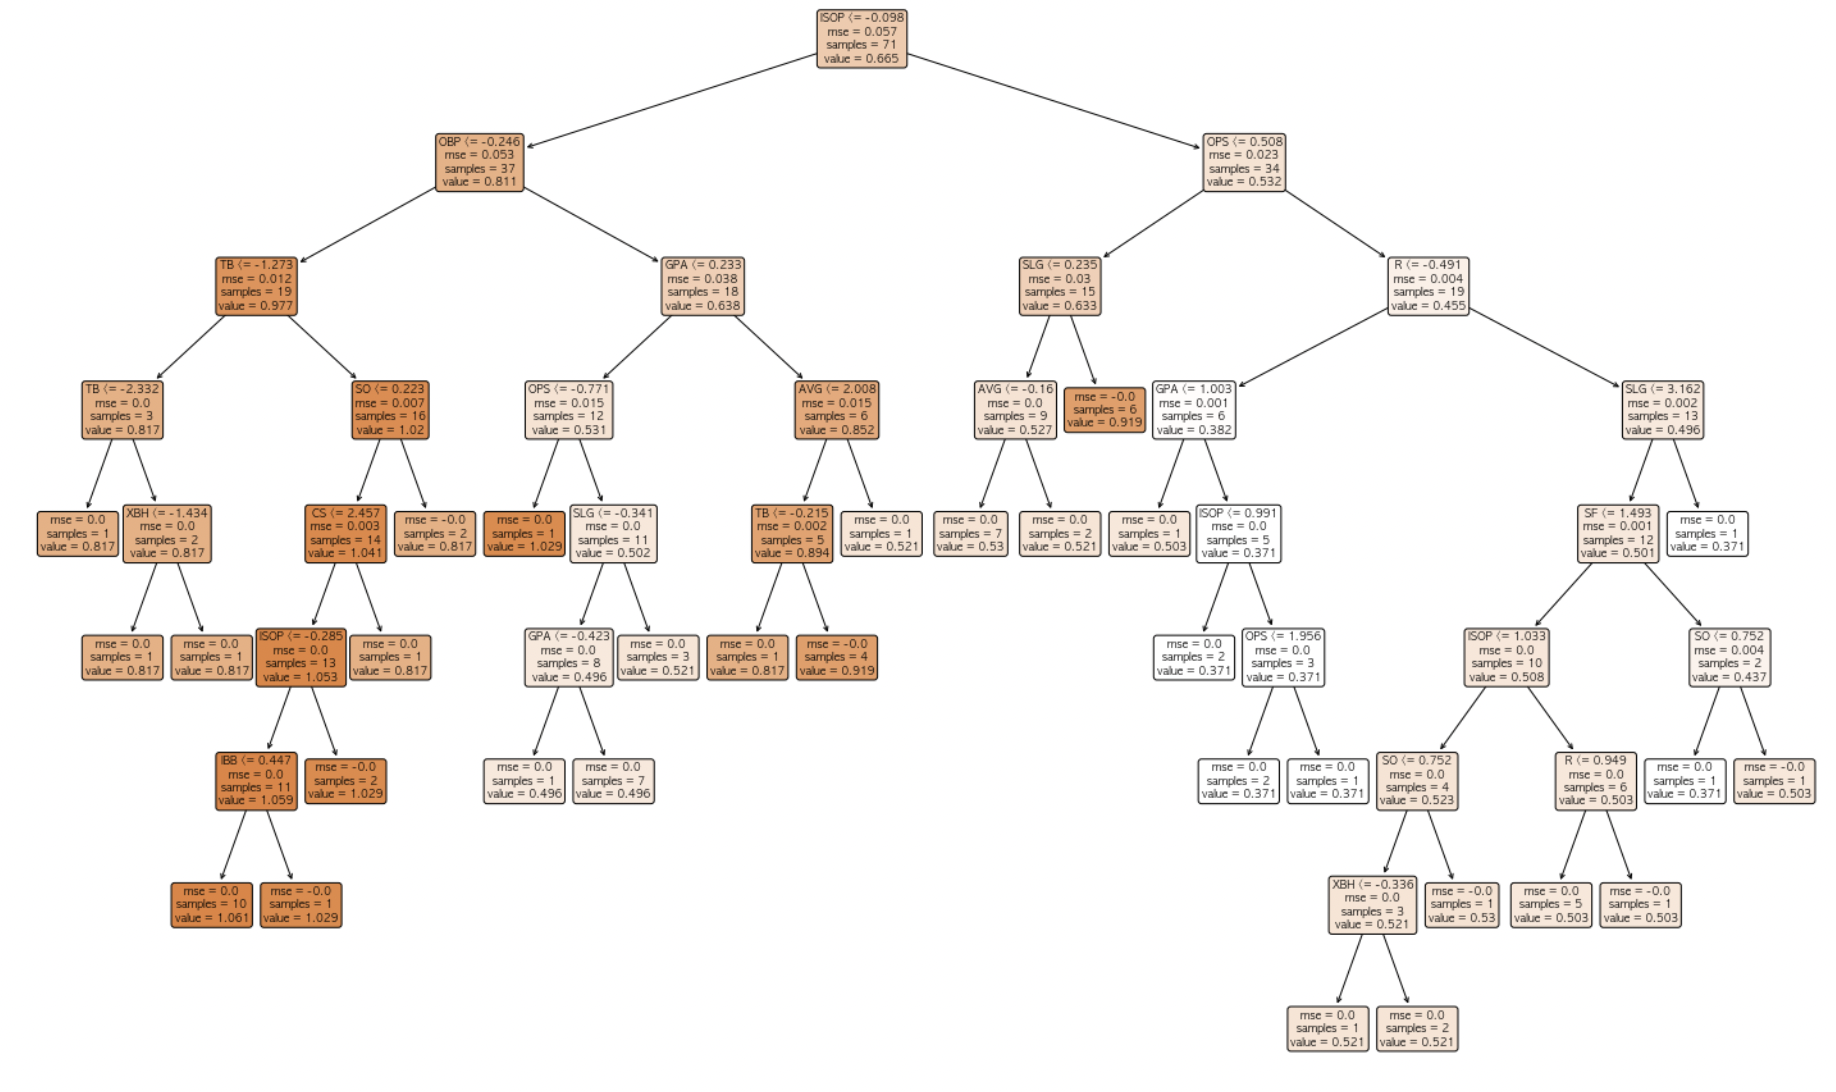

**GridSearchCV**

- 클래스 객체에 fit 메서드를 호출하면 grid search를 사용하여 **자동으로 복수개의 내부 모형을 생성하고 
  이를 모두 실행시켜서 최적 파라미터를 찾아준다.** 

### 3-4. 최종 알고리즘 선택

<AxesSubplot:>

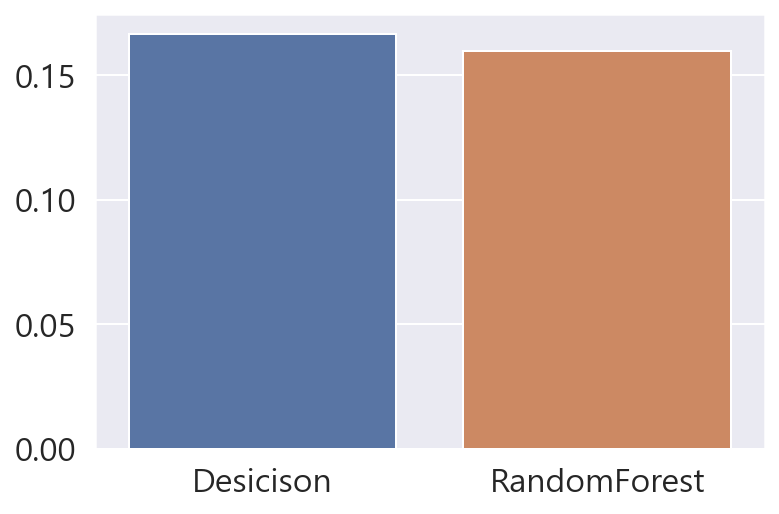

In [110]:
sns.barplot(x=['Desicison', 'RandomForest'], y=[0.1664, 0.1598])

RMSE 값으로 판단한 결과, 가장 좋은 모델은 RandomForestRegressor였다. 

## 4. 랜덤포레스트 성능 향상

### 4-1. 중요변수 선택

**1. 상관계수가 절댓값 0.2 이 이하인 변수들을 뽑는다.**

In [60]:
# 0.2 미만인 feature들을 drop 합니다. 
y_corrs       = df_anal.drop("y", axis=1).corrwith(df_anal["y"])
low_features  = abs(y_corrs)[abs(y_corrs) < 0.2].index
importance    = df_anal.drop(low_features, axis=1)
importance

ORD        AB        HR       HBP        SO       AVG       OBP  \
0    0.920209 -0.398870  1.764949 -0.837042  2.516586 -2.373753  0.205535   
1    0.920209 -0.398870 -0.819654 -0.837042  0.399419 -1.111915 -0.917786   
2    0.920209 -0.398870  0.903414 -0.837042  0.752280 -0.767777 -0.698006   
3    0.920209  0.655025  1.764949 -0.837042  1.458003 -0.217157 -0.063085   
4    0.920209  0.655025 -0.819654 -0.837042  1.810864 -0.033617 -0.160765   
..        ...       ...       ...       ...       ...       ...       ...   
139 -1.217051  1.445446  0.041880  0.532663 -1.012025  0.379348 -0.453806   
140  0.207789  1.972394 -0.819654 -0.837042 -1.012025  0.379348 -0.453806   
141  0.207789  0.655025 -0.819654 -0.837042 -0.659164  0.264635 -0.551486   
142  0.207789  0.655025 -0.819654 -0.837042 -1.364886  0.517003 -0.258445   
143  0.207789  0.128078 -0.819654  0.532663 -0.659164 -0.744835 -1.381767   

          SLG      ISOP       OPS       GPA      y  
0   -0.215912  0.985233 -0.101076 -0.031538  0.530  
1    0.524833  1.213944  0.113418 -0.107230  0.530  
2   -0.025720  0.383360 -0.238964 -0.334305  0.530  
3    0.745055  1.009308  0.550065  0.447843  0.530  
4    0.574884  0.696334  0.381535  0.296459  0.530  
..        ...       ...       ...       ...    ...  
139 -0.105801 -0.326850 -0.223644 -0.283844  1.061  
140 -0.095791 -0.314813 -0.215983 -0.283844  1.061  
141 -0.195891 -0.375000 -0.315569 -0.384766  1.061  
142 -0.105801 -0.399075 -0.162360 -0.182922  1.061  
143 -1.367069 -1.253735 -1.479962 -1.494912  1.061  

[144 rows x 12 columns]

**왜? 0.2를 기준으로 하였는가?**

- 기본적으로 상관계수의 계수가 절댓값이 0.3부터 상관관계가 있다는 것으로 판단되는데
  0.3으로 했을때보다 0.2로 했을때가 우수하였다.  
 
- corr < 0.2
    - R2 score:0.7082  |  RMSE:0.1367  |  MAE:0.1094    (random forest 기준)
    
- corr < 0.3
    - R2 score:0.6294  |  RMSE:0.1540  |  MAE:0.1223 (random forest 기준)

In [61]:
importance.columns

Index(['ORD', 'AB', 'HR', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'ISOP', 'OPS',
       'GPA', 'y'],
      dtype='object')

**2. 도메인 관점을 통하여 중요피처 선택**

In [62]:
# importance와 다른 점은 OPS가 제외됨.
selected_cols = ['ORD', 'AB', 'HR', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'ISOP', 'GPA']

**3.best_rfr.feature_importances_활용해서 피처 선택**

그렇게 해서 선택되어진 피처들로 다시 학습 데이터와 테스트 데이터를 분리한다. 

In [65]:
X = importance[selected_cols]
y = importance['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [66]:
rfr = RandomForestRegressor(random_state=42)
param_grid = {
    'max_depth' : [10,50,100,200],
    'max_leaf_nodes' : [50,100,200],
    'criterion' : ['mae', 'mse']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1, n_jobs=-1, scoring='r2')
CV_rfr.fit(X_train, y_train)

best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

y_pred = best_rfr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred=y_pred) ## R2 score
rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred)) ## RMSE
mae = mean_absolute_error(y_true = y_test, y_pred=y_pred) ## MAE

print('Random Forest Regressor')
print(f'R2 score:{r2score:0.4f}', f'RMSE:{rmse:0.4f}', f'MAE:{mae:0.4f}', sep='  |  ')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Random Forest Regressor
R2 score:0.7084  |  RMSE:0.1366  |  MAE:0.1080


### 4-2. 성능향상 그래프

- original : 원본 

- update_1 : 반응변수와 설명변수 간의 **상관계수가 절댓값 0.2 미만**인 피처 제거 후의 데이터 
    
- update_2 : update_1에서 도메인 기반으로 'OPS' 피처를 제거후 데이터

In [80]:
performance = pd.DataFrame({'R2_score' : [0.6013, 0.7082, 0.7084],
                            'RMSE' : [0.1598, 0.1367, 0.1366],
                            'MAE' : [0.1309, 0.1094, 0.1080],
                            'MODEL' : ['original', 'update_1', 'update_2']})
performance = performance.set_index('MODEL')
performance

R2_score    RMSE     MAE
MODEL                             
original    0.6013  0.1598  0.1309
update_1    0.7082  0.1367  0.1094
update_2    0.7084  0.1366  0.1080

In [93]:
performance

MODEL  R2_score    RMSE     MAE
0  original    0.6013  0.1598  0.1309
1  update_1    0.7082  0.1367  0.1094
2  update_2    0.7084  0.1366  0.1080

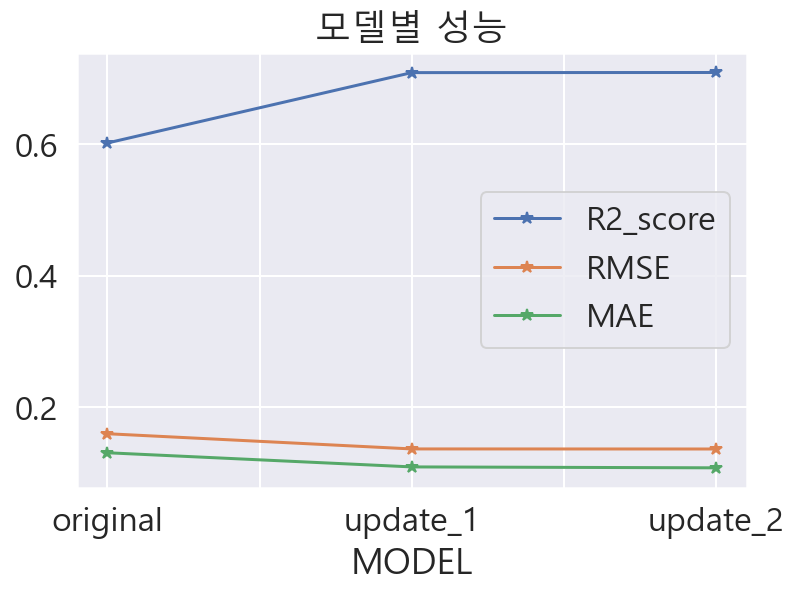

In [109]:
# performance = performance.reset_index('MODEL')
plt.rc("font", family="Malgun Gothic") #한글 폰트 
plt.rc("axes", unicode_minus=False) #마이너스 코드 

performance.plot(x='MODEL', kind='line', marker='*')
plt.title('모델별 성능')
plt.show()


## 5. 2021년 대표선수들 OPS 예측

In [73]:
kbo_21 = pd.read_csv("2021_tokyo_player_season.csv")

In [74]:
selected_cols = ['ORD', 'AB', 'HR', 'HBP', 'SO', 'AVG', 'OBP', 'SLG', 'ISOP', 'GPA']

In [75]:
selected_kbo_21 = kbo_21[selected_cols]
selected_kbo_21.head()

ORD    AB   HR  HBP   SO    AVG    OBP    SLG   ISOP    GPA
0    3  35.0  2.0  0.0  4.0  0.358  0.371  0.796  0.438  0.366
1    3  31.0  0.0  0.0  4.0  0.421  0.471  0.633  0.212  0.370
2    3  25.0  0.0  2.0  3.0  0.382  0.454  0.523  0.141  0.335
3    3  36.0  0.0  1.0  6.0  0.366  0.433  0.494  0.128  0.318
4    3  32.0  0.0  0.0  5.0  0.351  0.419  0.463  0.112  0.304

In [76]:
# 스케일링
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x : (x-series_mean) / series_std)
    return df

selected_kbo_21 = standard_scaling(selected_kbo_21, selected_kbo_21.columns)
selected_kbo_21.head(3)

ORD        AB        HR       HBP        SO       AVG       OBP  \
0 -0.055711  0.606747  0.932553 -0.557346 -0.315177  0.766299 -0.580765   
1 -0.055711 -0.530586 -0.837717 -0.557346 -0.315177  1.901033  1.629418   
2 -0.055711 -2.236586 -0.837717  2.415165 -0.690707  1.198578  1.253687   

        SLG      ISOP       GPA  
0  2.731156  3.137485  1.565403  
1  1.384862  0.676346  1.653694  
2  0.476321 -0.096843  0.881143

데이터를 스케일링을 끝으로 데이터 전처리를 완료하였다. 이를 바탕으로 예측을 하겠다.

In [77]:
y_pred = best_rfr.predict(selected_kbo_21)
y_pred

array([0.64791, 0.44643, 0.6733 , 0.75526, 0.7333 , 0.84624, 0.86585,
       0.97532, 0.91708, 0.6858 , 0.741  , 0.7746 , 0.8017 , 0.73567,
       0.75103, 0.83957, 1.01217, 0.85038, 0.95489, 0.77193, 0.82287,
       0.69831, 0.72668, 0.74913, 0.85076, 0.66656, 0.95238, 0.92566,
       0.91123, 0.9054 , 0.8342 , 0.90345, 0.90311, 0.8494 , 0.61282,
       0.60703, 0.57438, 0.54112, 0.61123, 0.47472, 0.55971, 0.55776,
       0.599  , 0.84953, 0.86977, 0.82459, 0.7886 , 0.8105 , 0.76597,
       0.7151 , 0.65582, 0.89229, 0.94156, 0.83429, 0.87896, 0.92728,
       0.93234, 0.94245, 0.86634, 0.96417, 0.87576, 0.99242, 0.99294,
       0.91253, 0.89933, 0.88719, 0.8454 , 0.5599 , 0.42268, 0.65731,
       0.41816, 0.40872, 0.38948, 0.38156, 0.44515, 0.37892, 0.58433,
       0.70549, 0.42505, 0.65571, 0.71208, 0.69766, 0.74232, 0.75585,
       0.73407, 0.5718 , 0.55903, 0.74057, 0.5626 , 0.56404, 0.57731,
       0.85648, 0.82376, 0.64419, 0.69783, 0.95634, 0.82018, 0.44934,
       0.60486, 0.47

예측한 결과의 모습인데, 반응변수인 y는 여러개의 행에서 동일시한 값이 들어갔다. 
이유는 선수들의 시즌 일별 데이터들을 8개로 묶었기 때문에 동일한 피처가 사용되었다. 
따라서 우리는 선수별로 묶어 평균값을 넣어 예측값을 도출하겠다. 

In [78]:
kbo_21["PLAYER"].value_counts()

김혜성    10
박해민     9
양의지     9
강백호     9
김현수     9
이정후     9
오지환     8
허경민     8
강민호     8
오재일     7
박건우     7
최주환     7
황재균     6
박민우     6
Name: PLAYER, dtype: int64

평균값 도출 함수를 만들어, 도쿄올림픽 야구대표팀 성적 예측한 결과이다. 

In [99]:
def mean_of_predict_scores(predict_scores):
    players_score     = {}
    bundle_of_matches = kbo_21["PLAYER"].value_counts()
    players           = bundle_of_matches.index
    start = 0
    for player in players:
        end = start + bundle_of_matches[player]
        mean_of_scores = round(np.mean(predict_scores[start:end]),3)
        players_score[player] = mean_of_scores
        start = end
    return players_score
mean_of_predict_scores(y_pred)

tokyo_pred = mean_of_predict_scores(y_pred)

tokyo_pred

pd.DataFrame(list(tokyo_pred.items()),  
                   columns=['PLAYER', 'OPS'])

PLAYER    OPS
0     김혜성  0.755
1     박해민  0.829
2     양의지  0.796
3     강백호  0.789
4     김현수  0.654
5     이정후  0.809
6     오지환  0.937
7     허경민  0.700
8     강민호  0.465
9     오재일  0.696
10    박건우  0.669
11    최주환  0.664
12    황재균  0.656
13    박민우  0.866

---

## 6. 결론

**한계점** 

- 예측값의 **경기단위 수가 8경기**밖에 안되는 만큼 오차가 발생할 확률이 높다. 


- 야구를 하는 나라들이 별로 없어 올림픽 대회와 프리미어12 대회 참가팀이 크게는 차이는 없지만 <br>
  야구성적이라는 것이 **상대적인 기록**이기 때문에 상대팀을 고려하지 않은 현 모델에서는 한계점이 드러난다. 
  

**향후 모델 개선점**

- 머신러닝의 핵심인 더 나은 **feature engineering**을 거치게 된다면 좋은 예측력을 가질 수 있다고 파악된다.

---